Climate estimatation

EDA

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
file_path = './climate_train.csv'
data = pd.read_csv(file_path)

데이터 파악

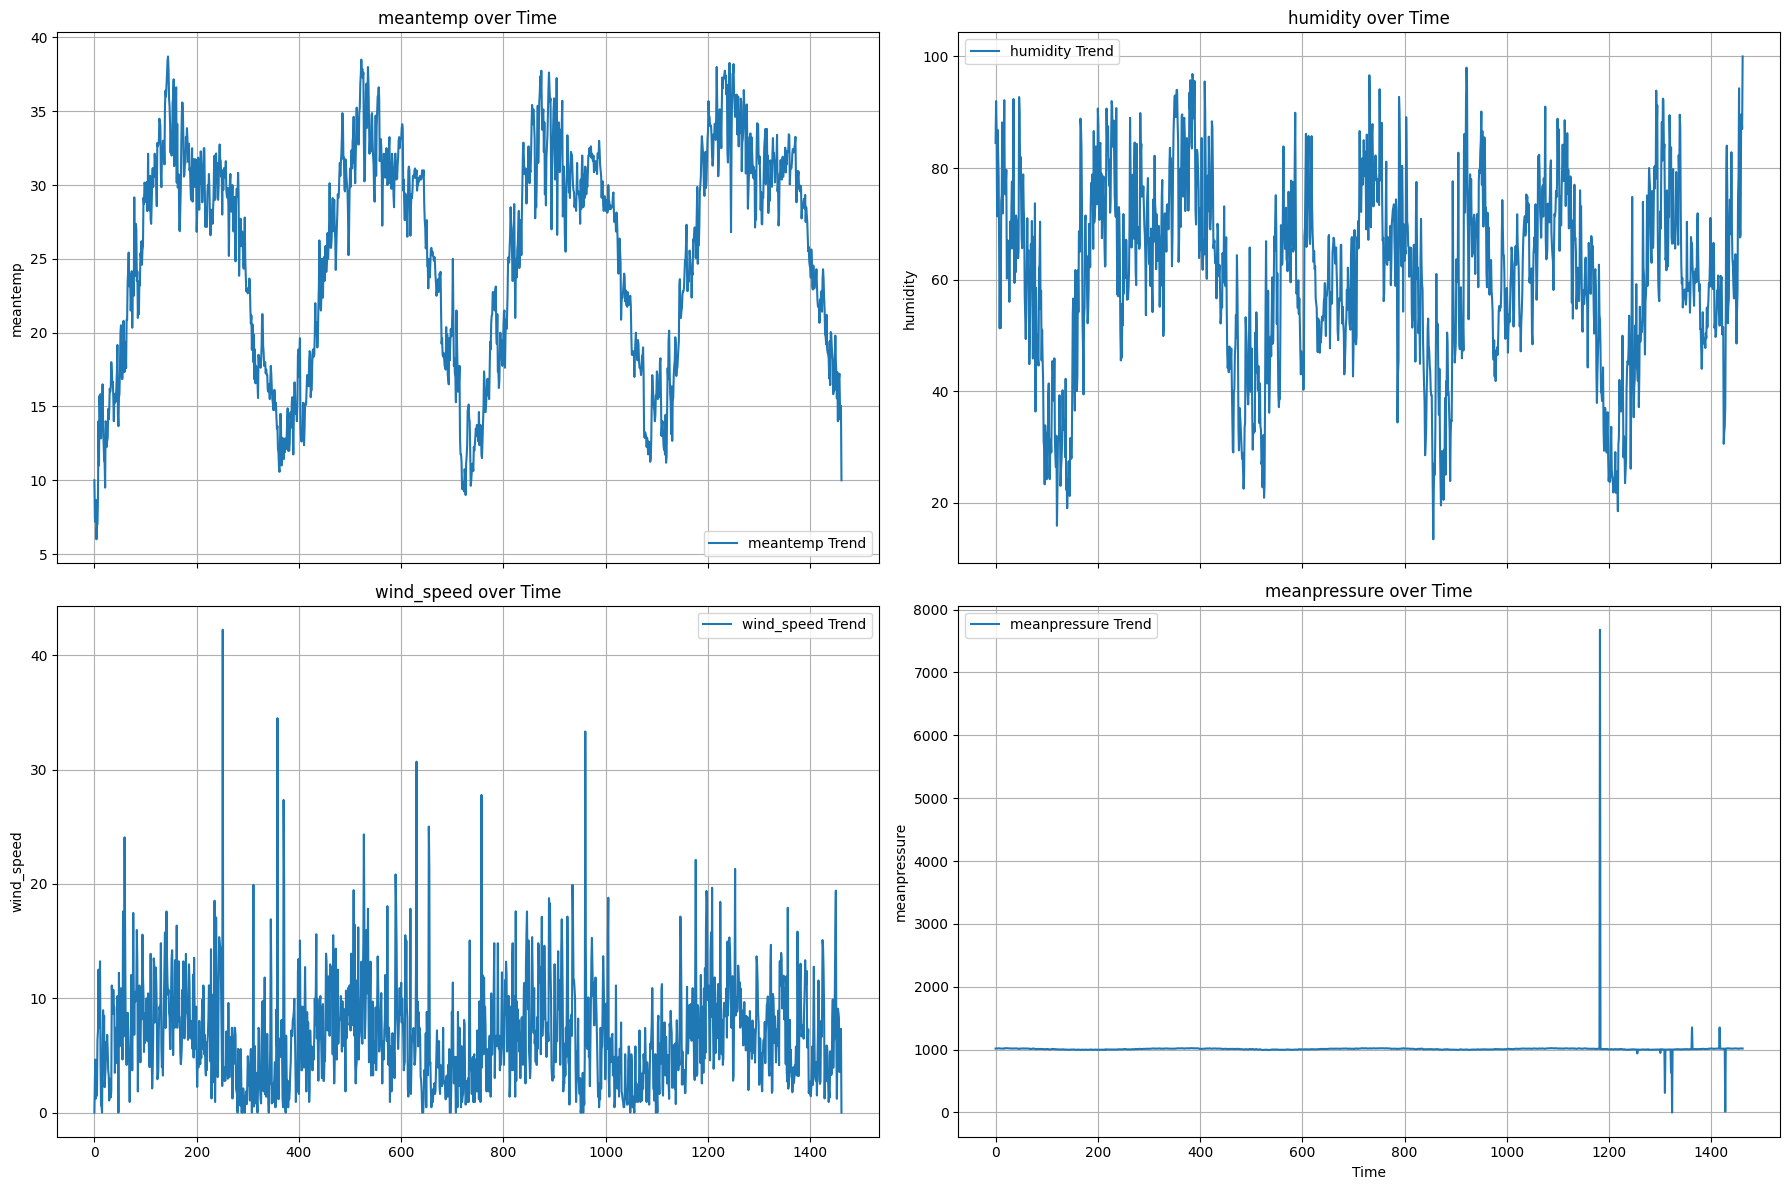

In [6]:
# 2x2 격자로 데이터를 시각화
fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
variables = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

for i, var in enumerate(variables):
    ax = axs[i // 2, i % 2]  # 2x2 grid
    ax.plot(data.index, data[var], label=f'{var} Trend')
    ax.set_title(f'{var} over Time')
    ax.set_ylabel(var)
    ax.legend()
    ax.grid()

# 공통 X축 레이블 설정
plt.xlabel("Time")
plt.tight_layout()
plt.show()

이상치 파악, 변환

In [8]:
#IQR
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return (series < lower_bound) | (series > upper_bound)

outliers_meanpressure = detect_outliers(data['meanpressure'])
outliers_wind_speed = detect_outliers(data['wind_speed'])

outliers_data = data[outliers_meanpressure | outliers_wind_speed]

outliers_data.head()


,date,meantemp,humidity,wind_speed,meanpressure
59,2013-03-01,17.333333,49.333333,24.066667,1016.333333
235,2013-08-24,32.000000,71.250000,18.525000,1000.333333
251,2013-09-09,31.000000,57.500000,42.220000,1007.000000
311,2013-11-08,18.000000,82.200000,19.912500,1015.625000
358,2013-12-25,13.666667,63.166667,34.487500,1020.625000


In [16]:
#이상치 변환
data.loc[outliers_meanpressure, 'meanpressure'] = None
data.loc[outliers_wind_speed, 'wind_speed'] = None

#선형보간
data['meanpressure'].interpolate(inplace=True)
data['wind_speed'].interpolate(inplace=True)

TypeError: unhashable type: 'Series'

Modeling

SARIMAX

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = data
test_data = pd.read_csv('./climate_test.csv')

# 시계열 분석을 위한 datetime 객체 변환
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# 단변량 예측만 가능
# 일반적인 시계열 분석에서 사용 되는 초깃값들 order, seasonal_order
sarimax_model = SARIMAX(
    train_data['meantemp'],
    exog=train_data[['humidity', 'wind_speed', 'meanpressure']],
    order=(5, 1, 0),
    seasonal_order=(1, 1, 1, 12)
)
# 학습
sarimax_fit = sarimax_model.fit(disp=False)

# 예측
sarimax_forecast = sarimax_fit.forecast(
    steps=len(test_data),
    exog=test_data[['humidity', 'wind_speed', 'meanpressure']]
)

# 평가
sarimax_rmse = np.sqrt(mean_squared_error(test_data['meantemp'], sarimax_forecast))

print("SARIMAX Forecast (first 5 predictions):")
print(sarimax_forecast.head())
print(f"\nSARIMAX RMSE: {sarimax_rmse:.2f}")


c:\Users\peter\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\peter\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMAX Forecast (first 5 predictions):
2017-01-02    11.511667
2017-01-03    13.141560
2017-01-04    13.129291
2017-01-05    15.518843
2017-01-06    15.166841
Freq: D, Name: predicted_mean, dtype: float64

SARIMAX RMSE: 5.25


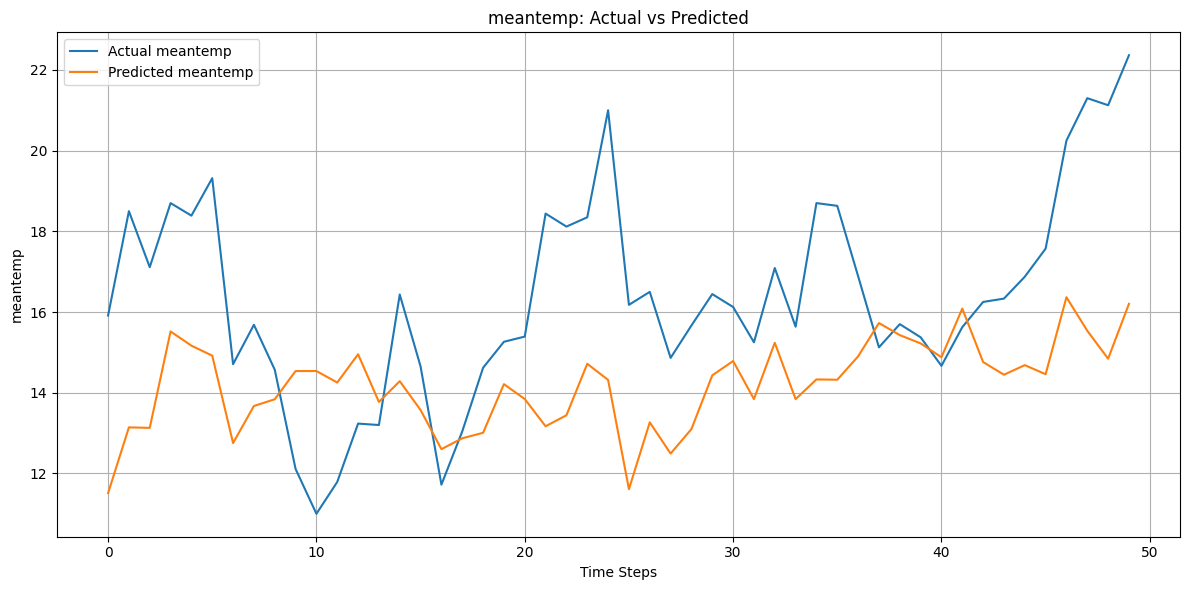

In [11]:
# SARIMAX 예측 결과와 실제 값을 비교하는 그래프 생성
def plot_sarimax_comparison(test_data, forecast, variable, start_idx=0, end_idx=50):
    plt.figure(figsize=(12, 6))
    plt.plot(
        range(start_idx, end_idx),
        test_data[variable].iloc[start_idx:end_idx],
        label=f"Actual {variable}",
    )
    plt.plot(
        range(start_idx, end_idx),
        forecast[start_idx:end_idx],
        label=f"Predicted {variable}",
    )
    plt.title(f"{variable}: Actual vs Predicted")
    plt.xlabel("Time Steps")
    plt.ylabel(variable)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# SARIMAX 결과와 실제 값 비교
plot_sarimax_comparison(test_data, sarimax_forecast, 'meantemp', start_idx=0, end_idx=50)


VAR

In [12]:
from statsmodels.tsa.api import VAR

train_var = train_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
test_var = test_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]

#모델 학습, 시차 고려, aic를 사용하여 최적의 lag 차수 선택
var_model = VAR(train_var)
var_fit = var_model.fit(maxlags=15, ic='aic') 

# 예측
lag_order = var_fit.k_ar  
var_forecast = var_fit.forecast(train_var.values[-lag_order:], steps=len(test_var))

# 결과 정리
forecast_df = pd.DataFrame(var_forecast, index=test_var.index, columns=train_var.columns)

# 평가
var_rmse = {
    col: np.sqrt(mean_squared_error(test_var[col], forecast_df[col])) for col in train_var.columns
}

print("VAR Forecast (first 5 predictions):")
print(forecast_df.head())
print("\nVAR RMSE:")
for variable, rmse in var_rmse.items():
    print(f"{variable}: {rmse:.2f}")


VAR Forecast (first 5 predictions):
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  12.028794  90.708949    1.747757   1016.501206
2017-01-02  12.863966  88.203038    2.650095   1016.893601
2017-01-03  13.592451  86.051972    3.384729   1016.675432
2017-01-04  13.690178  85.416502    4.304781   1016.787434
2017-01-05  13.822136  84.854261    4.061935   1016.879328

VAR RMSE:
meantemp: 5.81
humidity: 19.10
wind_speed: 4.55
meanpressure: 5.29


c:\Users\peter\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


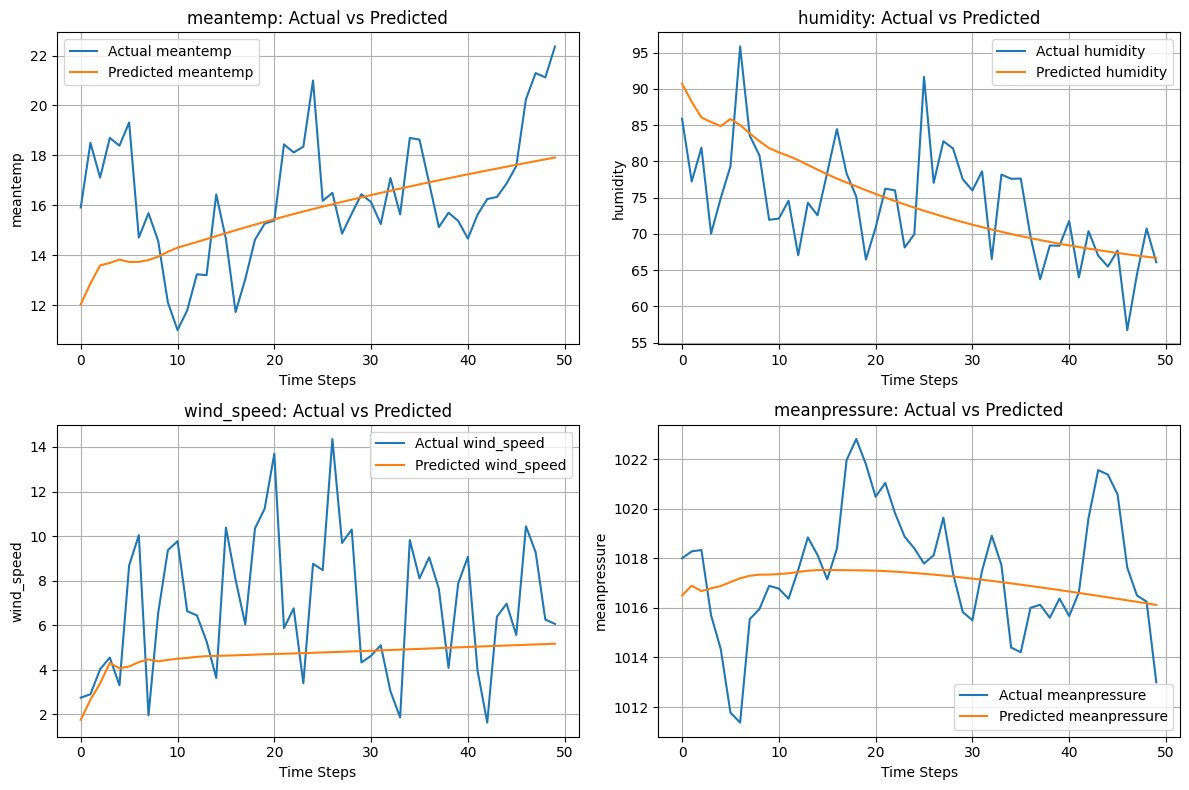

In [ ]:
# 2x2 격자로 VAR 예측 결과와 실제 값을 비교하는 그래프 생성
def plot_var_comparison(test_data, forecast_df, variables, start_idx=0, end_idx=50):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
    axes = axes.flatten()

    for i, var in enumerate(variables):
        axes[i].plot(
            range(start_idx, end_idx),
            test_data[var].iloc[start_idx:end_idx],
            label=f"Actual {var}",
        )
        axes[i].plot(
            range(start_idx, end_idx),
            forecast_df[var].iloc[start_idx:end_idx],
            label=f"Predicted {var}",
        )
        axes[i].set_title(f"{var}: Actual vs Predicted")
        axes[i].set_xlabel("Time Steps")
        axes[i].set_ylabel(var)
        axes[i].legend()
        axes[i].grid()

    for j in range(len(variables), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# VAR 예측 결과와 실제 값 비교
plot_var_comparison(test_var, forecast_df, ['meantemp', 'humidity', 'wind_speed', 'meanpressure'], start_idx=0, end_idx=50)


LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 선택한 변수
variables = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

# 데이터 정규화 (Min-Max Scaling)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[variables])
test_scaled = scaler.transform(test_data[variables])

# LSTM 입력 데이터 생성
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

#모델이 학습할 과거 데이터의 길이 time_step 정의
time_steps = 10
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# LSTM 입력 형태로 변환 (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], time_steps, len(variables)))
X_test = X_test.reshape((X_test.shape[0], time_steps, len(variables)))

# LSTM 모델 정의
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, len(variables))),
    Dense(len(variables))  # 각 변수의 예측값 출력
])

model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 결과 역정규화
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# RMSE 계산 (각 변수별)
lstm_rmse = {
    variables[i]: np.sqrt(mean_squared_error(y_test_rescaled[:, i], y_pred_rescaled[:, i]))
    for i in range(len(variables))
}

# 결과 출력
print("LSTM 예측 결과 (일부 샘플):")
print(pd.DataFrame(y_pred_rescaled, columns=variables).head())
print("\nLSTM RMSE:")
print(lstm_rmse)


Epoch 1/20


c:\Users\peter\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2088
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0347 
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135
Epoch 16/20
46/46 ━━━━━━━━━━━

In [23]:
original_data = test_data[variables][time_steps:].reset_index(drop=True)
restored_data = pd.DataFrame(y_test_rescaled, columns=variables)

# 비교 출력
print("Original Data (First 5 Rows):")
print(original_data.tail())

print("\nRestored Data After Inverse Transformation (First 5 Rows):")
print(restored_data.tail())

Original Data (First 5 Rows):
     meantemp   humidity  wind_speed  meanpressure
99     34.500  27.500000    5.562500    998.625000
100    34.250  39.375000    6.962500    999.875000
101    32.900  40.900000    8.890000   1001.600000
102    32.875  27.500000    9.962500   1002.125000
103    32.000  27.142857   12.157143   1004.142857

Restored Data After Inverse Transformation (First 5 Rows):
     meantemp   humidity  wind_speed  meanpressure
99     34.500  27.500000    5.562500    998.625000
100    34.250  39.375000    6.962500    999.875000
101    32.900  40.900000    8.890000   1001.600000
102    32.875  27.500000    9.962500   1002.125000
103    32.000  27.142857   12.157143   1004.142857


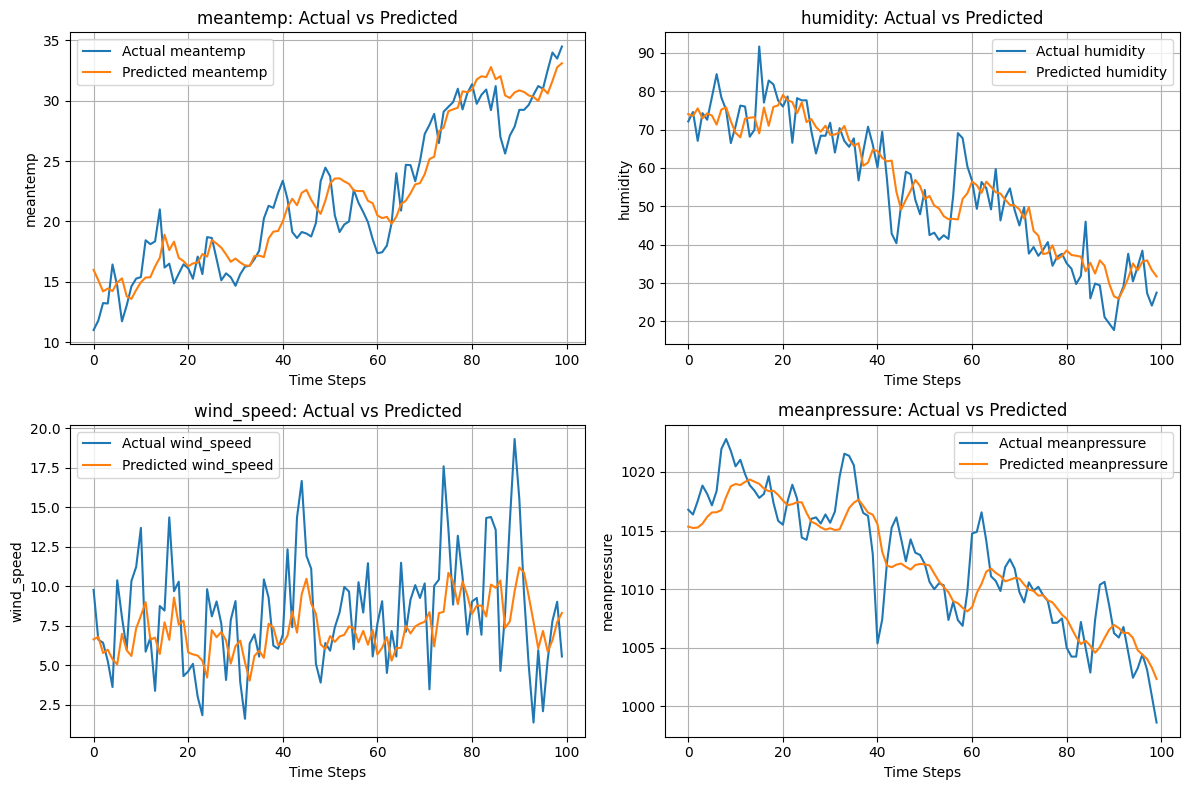

In [22]:
# 2x2 격자 그래프 비교
def plot_comparison_grid(y_test_rescaled, y_pred_rescaled, variables, start_idx=0, end_idx=100):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
    axes = axes.flatten()

    for i, var in enumerate(variables):
        axes[i].plot(
            range(start_idx, end_idx),
            y_test_rescaled[start_idx:end_idx, i],
            label=f"Actual {var}",
        )
        axes[i].plot(
            range(start_idx, end_idx),
            y_pred_rescaled[start_idx:end_idx, i],
            label=f"Predicted {var}",
        )
        axes[i].set_title(f"{var}: Actual vs Predicted")
        axes[i].set_xlabel("Time Steps")
        axes[i].set_ylabel(var)
        axes[i].legend()
        axes[i].grid()

    # 나머지 빈 공간 숨기기 (변수가 4개 미만일 경우)
    for j in range(len(variables), len(axes)):
        axes[j].axis('off')

    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

# 실제 값과 예측 값을 비교
plot_comparison_grid(y_test_rescaled, y_pred_rescaled, variables, start_idx=0, end_idx=100)
